# Introduction

Key takeaways
* Installing packages
* Handling data with pandas
* Unzipping Files with Python
* Using seaborn for vizualization
* Using matplotlib for vizualization
* Creating Lambda functions
* Deploying machine learning models
* Evaluating machine learning results
* Validating aggregates

# The CRISP-DM Process

For this project, I will be following the CRISP-DM (Cross-industry standard process for data mining) process.

![alt text](https://codesachin.files.wordpress.com/2015/09/crisp-dm.gif)
The process follows these steps:
    1. Pick a dataset
    2. Generate business questions
    3. Obtain data understanding
    4. Prepare the data
    5. Analyze, Model, and Visualize
    6. Evaluate your analysis
    7. Communicate business insights   
 
 
    
This project approaches these steps in the following way:
    1. Boston & Seattle Airbnb Open Data 
    2. I am starting with these business questions.
        a. What is the mission of Airbnb?
        b. What is more likely to cause bad reviews?
        c. What is the cost of bad reviews?
        d. What is the value of good reviews?
    3. Steps 3 to 6 will be conducted using a Jupyter notebook, and some Python 3 magic!

**Process Character Legend**:
* **RC** - Removed Columns
* **RR** - Removed Rows
* **T** - Transformation
* **E** - Engineering

# Data Handling

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
from helper import unzip_files, read_concat
from helper import cleaning_dollar
from helper import cleaning_percent
from helper import AnalysisStatus
from helper import DummySplit
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
%matplotlib inline
plt.style.use('ggplot')

## Encoder

In [2]:
encoder = OneHotEncoder()

# Preparing for Extract
---

In [3]:
# getting zip file names
data_zip = os.listdir('data')
data_zip

['boston-airbnb-open-data.zip',
 'boston_airbnb_open_data',
 'extra_seattle',
 'seattle',
 'seattle.zip']

In [4]:
# extracting datasets
folder_names = unzip_files(data_zip)
folder_names

File already extracted!
File already extracted!
File already extracted!


['data\\boston_airbnb_open_data', 'data\\seattle']

In [5]:
[os.listdir(folder_name) for folder_name in folder_names]

[['calendar.csv', 'listings.csv', 'reviews.csv'],
 ['calendar.csv', 'listings.csv', 'reviews.csv']]

# Extracting the Calendar Dataset
---

In [6]:
calendar = read_concat(folder_names, 'calendar.csv')

In [7]:
calendar.query("available=='f'").price.unique()

array([nan], dtype=object)

## Distribution of calendar features

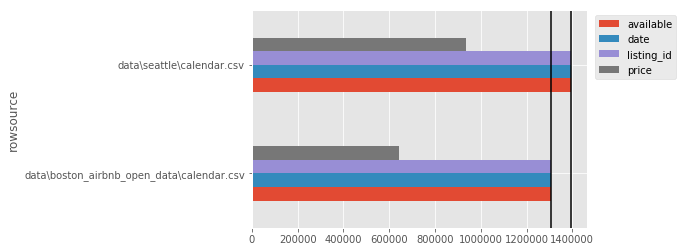

In [8]:
calendar.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in calendar.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

## Calendar Extraction Analysis Results

We can see that prices are missing. All other columns seem completed.

# Extracting the Listings Dataset
---

In [9]:
listings = read_concat(folder_names, 'listings.csv')

## Distribution of listings features

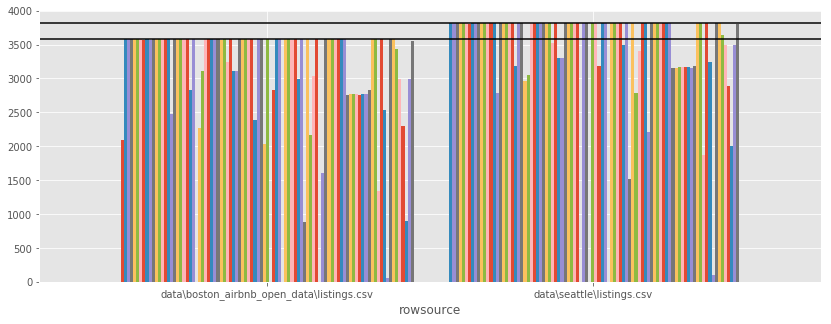

In [10]:
listings\
    .groupby('rowsource')\
    .count()\
    .plot.bar(legend=False, figsize=(14, 5), rot=0, width=.9);
for x in listings.rowsource.value_counts().values:
    plt.hlines(x, -1, 2);

##  Distribution of listings nulls

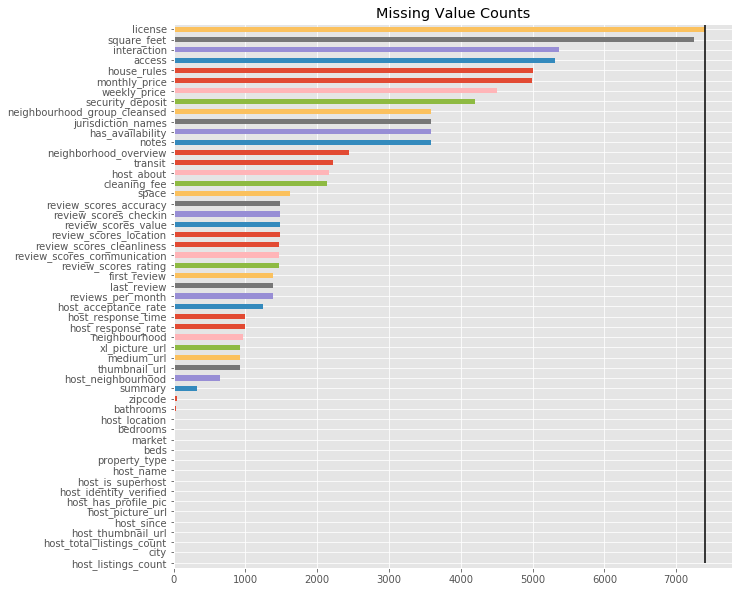

In [11]:
listing_nulls = listings.isnull().sum()\
    .where(lambda x: x>0)\
    .dropna()\
    .sort_values(ascending=True)

listing_nulls\
    .plot.barh(figsize=(10, 10), title="Missing Value Counts");
plt.vlines(listings.shape[0], 100, 0);

##  Distribution of listing nulls by rowsource and bucket null percentages

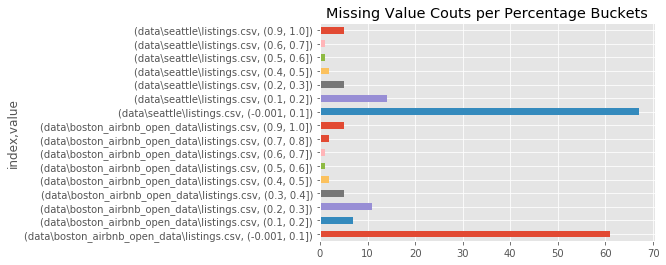

In [12]:
# Total columns by rowsource
totals_byrowsource = listings.rowsource.value_counts()

# Feature totals by rowsource
non_complete_listings = listings.groupby('rowsource').count()

# Feature totals by rowsource - totals, abs
non_complete_listings = non_complete_listings.subtract(totals_byrowsource, axis=0).abs()

# Get percentages of totals per rowsource
non_complete_listings = non_complete_listings.div(totals_byrowsource, axis=0)

# Melt data on rowsource
non_complete_listings = non_complete_listings.reset_index().melt(id_vars='index')

# Grouping by rowsource and provided column buckets
grouping = ['index', pd.cut(non_complete_listings.value, bins=10)]
non_complete_listings = non_complete_listings.groupby(grouping)
non_complete_listings = non_complete_listings.size()
non_complete_listings.plot.barh(title="Missing Value Couts per Percentage Buckets");

In [13]:
listings.isnull().sum().map({0:'Provided'}).fillna('Missing')\
    .to_frame('Status')\
    .groupby('Status')\
    .size()

Status
Missing     53
Provided    43
dtype: int64

## Listings Extraction Analysis Results

We can see that missing values are scattered in this dataset. These missing values need to be investigated  individually and possibly in groups. 

Only 43 column have completed values, 53 of them have missing values.

We can see that **license** and **squared_feet** are completely missing or significantly missing. For this reason we are removing these two features from the dataset and not wasting time analyzing them.

## **Removing Listings licensce and square_feet** --RC

In [14]:
remove_cols = ['license', 'square_feet']
listings.drop(remove_cols, axis=1, inplace=True)

# Extracting the Reviews Dataset
---

In [15]:
reviews = read_concat(folder_names, 'reviews.csv')

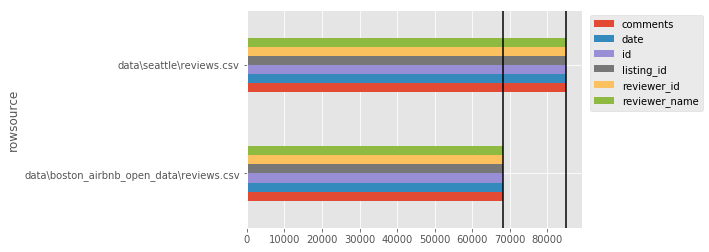

In [16]:
reviews.groupby('rowsource').count().plot.barh();
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left');
for x in reviews.rowsource.value_counts().values:
    plt.vlines(x, -1, 2)

## Reviews Extraction Analysis Results

Simple. Reviews are all complete.

# Understanding Calendar

##  First 5 Rows

In [17]:
calendar.head()

,available,date,listing_id,price,rowsource
0,f,2017-09-05,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
1,f,2017-09-04,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
2,f,2017-09-03,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
3,f,2017-09-02,12147973,NaN,data\boston_airbnb_open_data\calendar.csv
4,f,2017-09-01,12147973,NaN,data\boston_airbnb_open_data\calendar.csv


##  Availability Counts

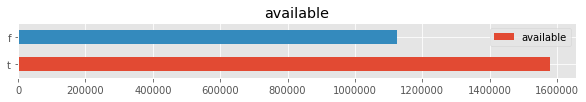

In [18]:
calendar.available.value_counts().plot.barh(
    figsize=(10, 1), title='available', legend=True);

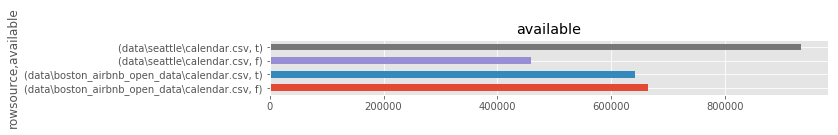

In [19]:
calendar.groupby(['rowsource', 'available']).available.count(
    ).plot.barh(figsize=(10, 1), title='available');

##  Price Formats

In [20]:
calendar.price.str.findall('\D').value_counts().to_frame('price_counts')

,price_counts
"[$, .]",1574314
"[$, ,, .]",3265


### **Cleaning Prices** --C

In [21]:
# Cleaning prices
calendar.price = cleaning_dollar(calendar.price)

# Converting date to datetime
calendar.date = pd.to_datetime(calendar.date)

In [22]:
calendar.price.unique()

array([ nan,  65.,  75., ...,  10.,  24., 817.])

## Price Line Trends by Dataset Source

### Price Trend with Filtered Nulls

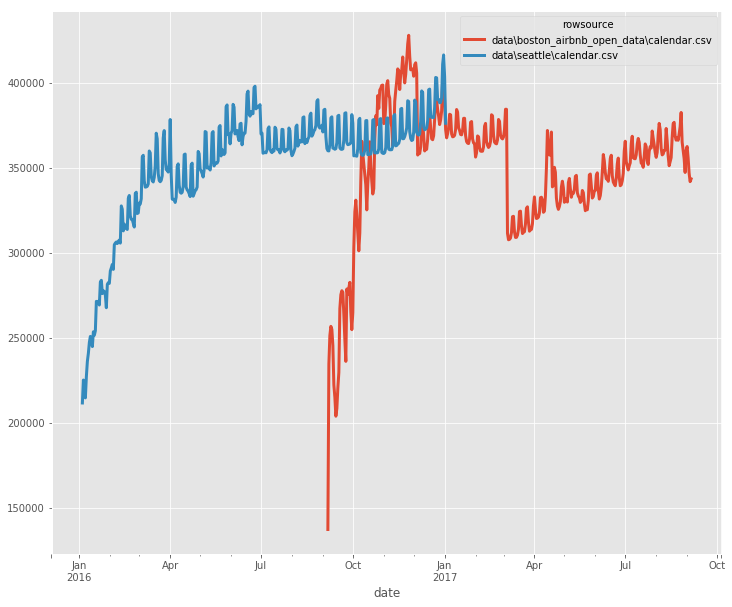

In [23]:
calendar.groupby(['rowsource', 'date'])\
    .agg({'price':'sum'})\
    .reset_index()\
    .pivot(index='date', columns='rowsource', values='price')\
    .plot.line(figsize=(12, 10), lw=3);

### Price Trend with Zeroed Nulls

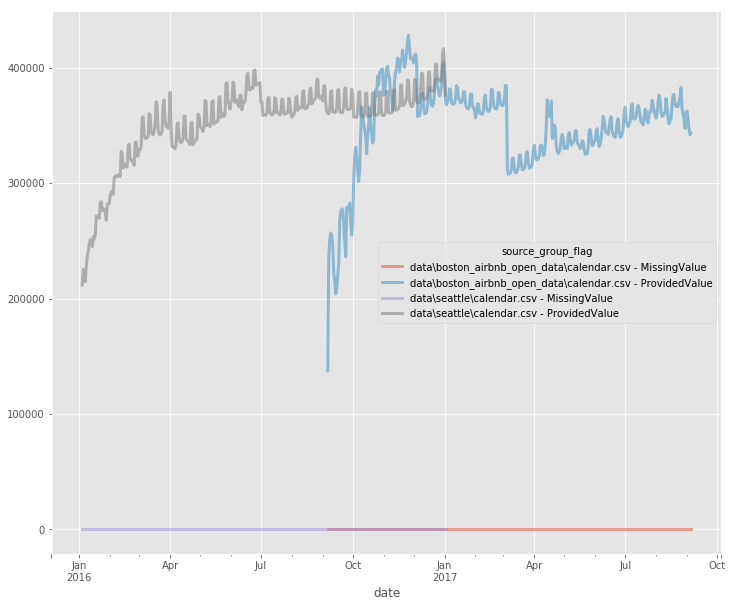

In [24]:
# Grouping missing values and provided values in a flag
calendar['provided_flag'] = calendar.price.fillna('MissingValue')
calendar.loc[calendar.provided_flag!='MissingValue', 'provided_flag'] = 'ProvidedValue'

# Grouping source files with missing values
calendar['source_group_flag'] = calendar.rowsource.str.cat(calendar.provided_flag, sep=' - ')

# Aggregate by source/flag
calendar_grp = calendar.groupby(['source_group_flag', 'date']).agg({'price':'sum'})
calendar_grp = calendar_grp.reset_index()

# Pivot table on source/flag to trend categories
calendar_grp = calendar_grp.pivot(index='date', columns='source_group_flag', values='price')

# Plot
calendar_grp.plot.line(figsize=(12, 10), lw=3, alpha=.5);

## Price Group/Flag Date Ranges

In [25]:
calendar.groupby('source_group_flag').agg({'date': ['min', 'max']})

date           
                                                          min        max
source_group_flag                                                       
data\boston_airbnb_open_data\calendar.csv - Mis... 2016-09-06 2017-09-05
data\boston_airbnb_open_data\calendar.csv - Pro... 2016-09-06 2017-09-05
data\seattle\calendar.csv - MissingValue           2016-01-04 2017-01-02
data\seattle\calendar.csv - ProvidedValue          2016-01-04 2017-01-02

## Difference Between Data Source Pricing Dates

In [26]:
# Month tranformation functions
month_func = lambda x: x.month
delta_month_func = lambda x: x.max_date.shift(1).apply(
    month_func) - x.max_date.apply(month_func)
delta_days_func = lambda x: x.max_date.shift(1) - x.max_date

calendar.groupby('rowsource').agg({
    'date': 'max'
}).rename(columns={
    'date': 'max_date'
}).assign(
    delta_month=delta_month_func, delta_days=delta_days_func).fillna('')

,max_date,delta_month,delta_days
rowsource,,,
data\boston_airbnb_open_data\calendar.csv,2017-09-05,,
data\seattle\calendar.csv,2017-01-02,8,246 days 00:00:00


## Understanding Calendar Results

We can see that there is more availability in Seattle listings. The total monthly trend prices are quite similar for both datasets. And the null values are scattered all within the min and max pricing dates. We are going to investigate these nulls during the listing null analysis.

Dates of datasets do not match. This could mean that these segments where serviced at different times. ARBNB must have started servicing Seattle before Boston. However, Seattle has no data from 2017-01-02 to 2017-09-05, 8 months or 246 days. Therefore, as a warning predictions using Seattle during these ranges will be incorrect. The same applies to Boston where dates do not crossover.

# Understanding Listings
---

## Analyzing Object Features of Listings

In [27]:
# Calculating missing percentages of total listings
missing_pct = listings.isnull().sum() / listings.shape[0]

# Listings examples with missing percentages
pd.options.display.max_rows = 100

listings.select_dtypes(include=object).dropna(
    axis=0, how='all').sample(1).T.merge(
        missing_pct.to_frame('missing'),
        left_index=True,
        right_index=True,
        how='left').iloc[:, [1, 0]].sort_values(
            'missing', ascending=False).style.bar()

,missing,2227
interaction,0.725652,nan
access,0.716872,nan
house_rules,0.676753,"No guests allowed. Please keep noise levels to a low/moderate rate. Please maintain the space with care & cleanliness. Loss of Key - A charge of $50 will be levied. What you do in your personal time is entirely up to you, but when staying at our place we have a strict no drug use policy. This is just the law… not so much one of our rules."
monthly_price,0.675132,nan
weekly_price,0.608132,nan
security_deposit,0.566662,$100.00
jurisdiction_names,0.484263,nan
neighbourhood_group_cleansed,0.484263,nan
has_availability,0.484263,nan
notes,0.483723,nan


## Analying Numeric Features of Listings

In [28]:
listings.filter(regex='id')
listings.select_dtypes(exclude=object).sample(4).T.merge(
    missing_pct.to_frame('missing'),
    left_index=True,
    right_index=True,
    how='left').iloc[:, [-1, 0, 1, 2, 3]].sort_values(
        'missing',
        ascending=False).style.format("{:2,.2f}").bar(subset=['missing'])

,missing,2139,2914,5250,3328
review_scores_accuracy,0.20,8.00,9.00,10.00,9.00
review_scores_checkin,0.20,10.00,10.00,9.00,10.00
review_scores_value,0.20,9.00,9.00,9.00,9.00
review_scores_location,0.20,9.00,8.00,8.00,8.00
review_scores_cleanliness,0.20,9.00,9.00,9.00,9.00
review_scores_communication,0.20,9.00,9.00,9.00,8.00
review_scores_rating,0.20,87.00,93.00,90.00,90.00
reviews_per_month,0.19,0.08,1.53,0.31,1.62
bathrooms,0.00,2.00,1.00,1.00,1.00
bedrooms,0.00,2.00,1.00,1.00,1.00


## Analyzing Date Features of Listings

In [29]:
listings.select_dtypes(include=object)\
    .apply(pd.to_datetime, errors='ignore')\
    .select_dtypes(include=np.datetime64).head()

,calendar_last_scraped,first_review,host_since,last_review,last_scraped
0,2016-09-06,NaT,2015-04-15,NaT,2016-09-07
1,2016-09-06,2014-06-01,2012-06-07,2016-08-13,2016-09-07
2,2016-09-06,2009-07-19,2009-05-11,2016-08-05,2016-09-07
3,2016-09-06,2016-08-28,2013-04-21,2016-08-28,2016-09-07
4,2016-09-06,2015-08-18,2014-05-11,2016-09-01,2016-09-07


In [30]:
listings['last_scraped'].unique()

array(['2016-09-07', '2016-01-04'], dtype=object)

## Understanding Listings Results

We can see that we have to do some imputations on the reviews for the numerical fields. For the object fields there are some numerical values that will have to be cleaned and some irrelevant columns such as urls and names. One thing to notice is that **amenities** and **host_verification** can be split and converted to dummy variables. These could be helpful to the model.

Perhaps the **calendar_last_scraped** feature has a meaningful link to the dataset. The other dates (**first_review, host_since, and last_review**) could be used to engineer new featuress. Only **last_scraped** seems to be irrelevant in this case since it only describes the date the datasets where extracted.

## **Removing last_scraped from Listings** --RC

In [31]:
listings.drop('last_scraped', axis=1, inplace=True)

# Uderstanding Reviews

##  Frist 5 Rows

In [32]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Id Relationships Lenght Box Plots

In [33]:
len_func = lambda x: x.str.len()

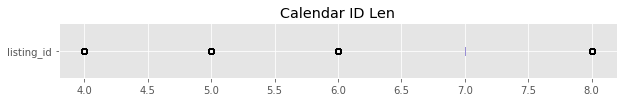

In [34]:
calendar.listing_id.astype(str).str.len()\
    .plot.box(vert=False, figsize=(10, 1), title="Calendar ID Len");

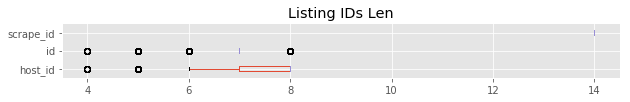

In [35]:
listings.filter(regex='id').select_dtypes(exclude=object).astype(str).apply(len_func)\
    .plot.box(vert=False, figsize=(10, 1), title="Listing IDs Len");

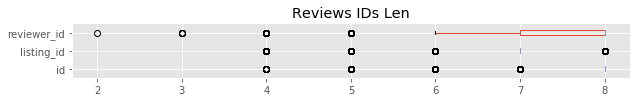

In [36]:
reviews.filter(regex='id').apply(lambda x: x.astype(str).str.len())\
    .plot.box(vert=False, figsize=(10, 1), title="Reviews IDs Len");

## Understanding Reviews Results

We can surely see these are just individual reviews for the listings. Given that there are reviewer-ids with length of 2 and 3 in the reviewers dataset and not in the listings dataset, we can assume that the listings don't include stays (missing records) for those host with 2 and 3 length-ids, but those host have reviews for the listings in the reviewer dataset.

* The listing dataset id is the primary key that relates to the listing_id of the calendar dataset.
* The scrape_id does not relate to anything in the downloaded dataset, so therefore it is irrelevant for the analysis. However, this id could be related to the calendar date since it could mean that the data was scraped druing a specific calendar date.
* The host_id in the listing dataset seems to be related to the reviewer_id of the reviews dataset.

# Calendar Granularity

## Calendar Duplicates

In [37]:
calendar_dup = calendar.groupby(
    ['date', 'listing_id', 'rowsource',
     'available']).size().to_frame('duplicates').query("duplicates>1")
calendar_dup.head()

,,,,duplicates
date,listing_id,rowsource,available,
2016-09-06,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-07,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-08,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-09,12898806,data\boston_airbnb_open_data\calendar.csv,t,2
2016-09-10,12898806,data\boston_airbnb_open_data\calendar.csv,t,2


In [38]:
calendar_price_dups = calendar_dup.reset_index().listing_id.unique()[0]
print(f"These are the id of price duplicates: \n {calendar_price_dups}")

These are the id of price duplicates: 
 12898806


### Examples of Calendar Duplicates

In [39]:
# Conditions
date_dup = calendar_dup.reset_index().date.astype(str).values.tolist()
date_filter = calendar.date.astype(
    str).apply(lambda x: True if x in date_dup else False)
filter_cond = (calendar.listing_id == 12898806) & date_filter

# Duplicate Examples
calendar.loc[filter_cond, :].sort_values(['date', 'listing_id']).head()

,available,date,listing_id,price,rowsource,provided_flag,source_group_flag
748850,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748873,t,2016-09-06,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748849,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748872,t,2016-09-07,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...
748848,t,2016-09-08,12898806,220.0,data\boston_airbnb_open_data\calendar.csv,ProvidedValue,data\boston_airbnb_open_data\calendar.csv - Pr...


## Calendar Granularity Results

There are 365 duplicates in the calendar dataset. These duplicates can be safely removed since they all share the same information. It does not really matter if we keep the first or last.

The granularity of the table is at the following level:
* Date
* Listing Id

## **Removing Calendar Duplicates** --RR

In [40]:
# Flag where there are no duplicates
keep_first = ~calendar.duplicated(subset=['date', 'listing_id'], keep='last')

# Remove duplicates by slicing
calendar_clean = calendar[keep_first]

# Calculate the difference beteween sizes
dup_count = calendar_dup.count().values[0]
dup_removed = calendar.shape[0] - calendar_clean.shape[0]

print(f"There where {dup_count} duplicates and {dup_removed} where removed.")

There where 365 duplicates and 365 where removed.


# Listings Granularity

## First 5 Rows

In [41]:
listings.head()

,access,accommodates,amenities,availability_30,availability_365,availability_60,availability_90,bathrooms,bed_type,bedrooms,...,smart_location,space,state,street,summary,thumbnail_url,transit,weekly_price,xl_picture_url,zipcode
0,"You will have access to 2 bedrooms, a living r...",4,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",0,0,0,0,1.5,Real Bed,2.0,...,"Boston, MA",The house has an open and cozy feel at the sam...,MA,"Birch Street, Boston, MA 02131, United States","Cozy, sunny, family home. Master bedroom high...",https://a2.muscache.com/im/pictures/c0842db1-e...,"The bus stop is 2 blocks away, and frequent. B...",NaN,https://a2.muscache.com/im/pictures/c0842db1-e...,02131
1,Apt has one more bedroom (which I use) and lar...,2,"{TV,Internet,""Wireless Internet"",""Air Conditio...",26,359,54,84,1.0,Real Bed,1.0,...,"Boston, MA",Small but cozy and quite room with a full size...,MA,"Pinehurst Street, Boston, MA 02131, United States",Charming and quiet room in a second floor 1910...,https://a1.muscache.com/im/pictures/39327812/d...,Plenty of safe street parking. Bus stops a few...,$400.00,https://a1.muscache.com/im/pictures/39327812/d...,02131
2,"I am living in the apartment during your stay,...",2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit...",19,319,46,61,1.0,Real Bed,1.0,...,"Boston, MA","Come stay with a friendly, middle-aged guy in ...",MA,"Ardale St., Boston, MA 02131, United States","Come stay with a friendly, middle-aged guy in ...",https://a2.muscache.com/im/pictures/6ae8335d-9...,"PUBLIC TRANSPORTATION: From the house, quick p...",$395.00,https://a2.muscache.com/im/pictures/6ae8335d-9...,02131
3,The basement has a washer dryer and gym area. ...,4,"{TV,Internet,""Wireless Internet"",""Air Conditio...",6,98,16,26,1.0,Real Bed,1.0,...,"Boston, MA",Most places you find in Boston are small howev...,MA,"Boston, MA, United States",Come experience the comforts of home away from...,https://a2.muscache.com/im/pictures/39764190-1...,There are buses that stop right in front of th...,NaN,https://a2.muscache.com/im/pictures/39764190-1...,NaN
4,You will have access to the front and side por...,2,"{Internet,""Wireless Internet"",""Air Conditionin...",13,334,34,59,1.5,Real Bed,1.0,...,"Boston, MA","Clean, attractive, private room, one block fro...",MA,"Durnell Avenue, Boston, MA 02131, United States","My comfy, clean and relaxing home is one block...",https://a1.muscache.com/im/pictures/97154760/8...,From Logan Airport and South Station you have...,NaN,https://a1.muscache.com/im/pictures/97154760/8...,02131


## Listings Duplicates

In [42]:
listings.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


## Listings Granularity Results

Plain and simple, there are no duplicates in this dataset. Great!

The granularity is at the id level. All other features are aggregates or normalized records.

# Reviews Granularity

## First 5 Rows

In [43]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


## Reviews Duplicates

In [44]:
reviews.groupby(['listing_id', 'reviewer_id', 'date',
                 'id']).size().to_frame('duplicates').query("duplicates>1")

,,,,duplicates
listing_id,reviewer_id,date,id,


In [45]:
reviews.groupby(['id']).size().to_frame('duplicates').query("duplicates>1")

,duplicates
id,


## Multiple Comments by Reviewer Relating to Listings

In [46]:
reviews_duplicated = reviews.groupby([
    'listing_id', 'reviewer_id', 'date'
]).size().to_frame("duplicates").query("duplicates>1").reset_index()
reviews_duplicated.style.bar(subset=['duplicates'])

,listing_id,reviewer_id,date,duplicates
0,447523,35607120,2015-07-06,2
1,568234,16199611,2014-09-08,2
2,1173306,8492099,2013-09-06,2
3,1529321,30877683,2015-05-15,2
4,3533224,39668556,2015-12-01,2
5,3866526,63239764,2016-03-18,2
6,3897963,47193495,2016-04-07,2
7,3897995,39441871,2016-03-23,2
8,3901439,9618964,2016-03-24,2
9,4402209,63239764,2016-03-25,2


### Examples of Multiple Reviews per Listing

In [47]:
reviews.merge(reviews_duplicated.drop('duplicates', axis=1),
              on=['listing_id', 'reviewer_id', 'date'], 
              how='left',
              indicator=True)\
    .query("_merge=='both'").head(6)\
    .style.background_gradient(subset=['reviewer_id'])

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource,_merge
6558,Nice neighborhood with a lot of local life and restaurants. Check in was simple and I was never bothered.,2015-05-15,32216803,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
6559,"A+ treatment all the way, you are an adult in a friendly part of town. Nice room and choice of two bathrooms.",2015-05-15,32223055,1529321,30877683,Jonathan,data\boston_airbnb_open_data\reviews.csv,both
29370,The reservation was canceled 23 days before arrival. This is an automated posting.,2014-09-08,19256952,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
29371,The reservation was canceled 24 days before arrival. This is an automated posting.,2014-09-08,19256954,568234,16199611,Lyn,data\boston_airbnb_open_data\reviews.csv,both
30826,My night at Aris house was perfect yet again! Thank you so much for hosting me Ari!!,2016-03-25,66858887,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both
30827,"The hosts communication was great, the listing was exactly as described definitely stay at Aris house if you need a place in Boston.",2016-03-25,66963792,4402209,63239764,Sandiya,data\boston_airbnb_open_data\reviews.csv,both


## Reviews Granularity Results

This dataset has no duplicates as well as listings. 

The granularity of the dataset is also at the id level. In this case the review id.

However, as it relates to listings, there are several reviews for the same listing during the same date. Some of them have automated comments that could be impacting the overall listing reviews.

> Granulated at the listing_id, reviewer_id, and date level. Some duplicates by automation. Some manual duplicates by reviewer with different commets for same date and listing.

# Sample Testing Relationships beteween Datasets

## Relationship between Null price and calendar_last_scraped

In [48]:
# Mergin listings to calendar on listing_id and listings id
target_columns = ['id', 'has_availability', 'price', 'calendar_last_scraped']

# Get geo columns
geo_columns = listings.select_dtypes(include=object).columns[-10:][:-6].tolist()
geo_columns.remove('space')
geo_columns.remove('street')
geo_columns.append('rowsource')

target_columns = target_columns + geo_columns

# Mergin clean calendar with listings
airbnb_evaluation_merge = calendar_clean.merge(
    listings[target_columns],
    left_on='listing_id',
    right_on='id',
    how='inner',
    suffixes=['', '_last'])

# Convert the calendar_last_scraped to datetime
airbnb_evaluation_merge.calendar_last_scraped = pd.to_datetime(
    airbnb_evaluation_merge.calendar_last_scraped)

# Celaning price_last
airbnb_evaluation_merge.price_last = cleaning_dollar(
    airbnb_evaluation_merge.price_last)

# Get relationship between calendar date and calendar_last_scrapped where they match
price_delta_func = lambda x: x.price - x.price_last
availability_match_func = lambda x: x.eval("has_availability == available"
                                           ).astype(int).map({0:'no match', 1:'match'})

# Assigning delta and match 
airbnb_evaluation_merge = airbnb_evaluation_merge.query(
    "date==calendar_last_scraped").assign(
        price_delta=price_delta_func,
        availability_match=availability_match_func)

# airbnb_evaluation_merge.head()

airbnb_evaluation_merge.rowsource.value_counts()

data\seattle\calendar.csv                    3818
data\boston_airbnb_open_data\calendar.csv    3585
Name: rowsource, dtype: int64

## Differences between Prices between Calendar and Listings

D:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


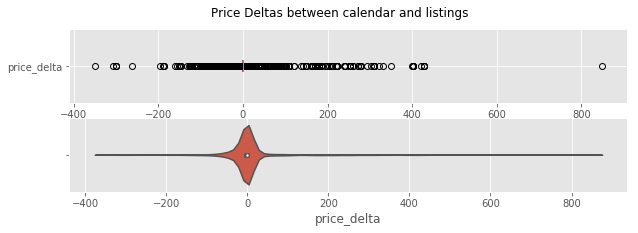

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 3))

plt.suptitle('Price Deltas between calendar and listings')
airbnb_evaluation_merge.query("price_delta==price_delta").price_delta.plot.box(
    vert=False, ax=ax[0])

data = airbnb_evaluation_merge.query("price_delta==price_delta")

sns.violinplot(
    x='price_delta',
    data=data,
    ax=ax[1])

plt.show()

## Differences between Availability from Calendar to Listings

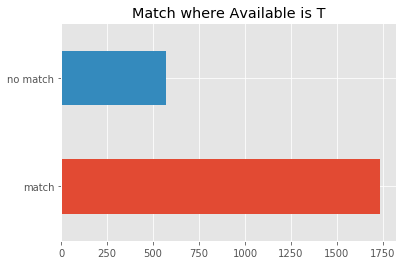

In [50]:
# Matching on t because listings only provided t
airbnb_evaluation_merge.query(
    "available=='t'").availability_match.value_counts().plot.barh(
        title='Match where Available is T');

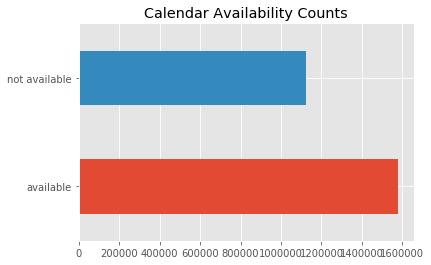

In [51]:
calendar_clean.available.map({
    't': 'available',
    'f': 'not available'
}).value_counts().plot.barh(title='Calendar Availability Counts');

## Testing Merge with rowsource and Geographical Columns

### First 5 Geo Rows from Sample

In [52]:
# Get only object columns
airbnb_evaluation_geo = airbnb_evaluation_merge[geo_columns]

airbnb_evaluation_geo.head()

,smart_location,state,rowsource
364,"Boston, MA",MA,data\boston_airbnb_open_data\calendar.csv
729,"Boston, MA",MA,data\boston_airbnb_open_data\calendar.csv
1094,"Boston, MA",MA,data\boston_airbnb_open_data\calendar.csv
1459,"Boston, MA",MA,data\boston_airbnb_open_data\calendar.csv
1824,"Boston, MA",MA,data\boston_airbnb_open_data\calendar.csv


### Geo Rows Aggrement with Rowsource from Sample

In [53]:
airbnb_evaluation_geo.groupby(geo_columns).size().to_frame('row_count').head()

,,,row_count
smart_location,state,rowsource,
"ALLSTON, MA",MA,data\boston_airbnb_open_data\calendar.csv,2
"Allston, MA",MA,data\boston_airbnb_open_data\calendar.csv,12
"Ballard, Seattle, WA",WA,data\seattle\calendar.csv,1
"Boston (Charlestown), MA",MA,data\boston_airbnb_open_data\calendar.csv,1
"Boston (Jamaica Plain), MA",MA,data\boston_airbnb_open_data\calendar.csv,1


### Cleaning state from Listings

In [54]:
listings.loc[:, 'state'] = listings.state.str.upper()
listings.state.value_counts()

WA    3818
MA    3585
Name: state, dtype: int64

## Looking for Meaningful Relationship Between Listing and Reivews

### Assessing Reviews and Ids from Sample

In [55]:
airbnb_evaluation_merge.filter(regex='revi|id').head().T

,364,729,1094,1459,1824
listing_id,12147973,3075044,6976,1436513,7651065
provided_flag,MissingValue,MissingValue,MissingValue,MissingValue,MissingValue
id,12147973,3075044,6976,1436513,7651065


### First 5 Comments

In [56]:
reviews.head()

,comments,date,id,listing_id,reviewer_id,reviewer_name,rowsource
0,My stay at islam's place was really cool! Good...,2013-05-21,4724140,1178162,4298113,Olivier,data\boston_airbnb_open_data\reviews.csv
1,Great location for both airport and city - gre...,2013-05-29,4869189,1178162,6452964,Charlotte,data\boston_airbnb_open_data\reviews.csv
2,We really enjoyed our stay at Islams house. Fr...,2013-06-06,5003196,1178162,6449554,Sebastian,data\boston_airbnb_open_data\reviews.csv
3,The room was nice and clean and so were the co...,2013-06-15,5150351,1178162,2215611,Marine,data\boston_airbnb_open_data\reviews.csv
4,Great location. Just 5 mins walk from the Airp...,2013-06-16,5171140,1178162,6848427,Andrew,data\boston_airbnb_open_data\reviews.csv


### Descriptive Statistics of Comments

In [57]:
comment_listing_counts = reviews.groupby('listing_id').size().to_frame(
    'comment_count').groupby('comment_count').size().reset_index().rename(
        columns={0: 'total_unique_listing_ids'})

comment_listing_counts[['comment_count']].describe()

,comment_count
count,229.000000
mean,127.720524
std,88.549820
min,1.000000
25%,58.000000
50%,115.000000
75%,180.000000
max,474.000000


### Unique Listing Id Comment Buckets

In [58]:
comment_listing_counts.groupby(
    pd.cut(comment_listing_counts.comment_count,
           bins=list(np.arange(0, 550, 50)))).sum()[[
               'total_unique_listing_ids'
           ]].reset_index().set_index('total_unique_listing_ids').rename(
               columns={'comment_count': 'comment_count_buckets'})

,comment_count_buckets
total_unique_listing_ids,
5157,"(0, 50]"
570,"(50, 100]"
167,"(100, 150]"
73,"(150, 200]"
28,"(200, 250]"
16,"(250, 300]"
4,"(300, 350]"
1,"(350, 400]"
2,"(400, 450]"


## Relationship betwee Datasets Results

We can see that there are some errors with the last scraped prices of the listing dataset and the prices of the calendar dataset for the same date, but most of the bulk of the data is concentrated around zero. This means that we could use this method to impute missing prices. To assess which method is best, we are comparing this method to the method used later, which it will probably be median imputation.

On the other hand, we cannot assume that the missing availability in the listings agrees with the the availability in the calendar dataset. Indeed there are differences between the time when the calendar data was scraped and the time when the listings was scrapped for aggregates--maybe hours. Therefore, using the listings has_availability column is not a viable solution. We will remove it completely.

The datasets agree on the state and the source file name. Thus, this is the join that will be used for the final training and testing dataset.

The relationship between listing dataset reviews and reviews dataset comments is by the listing_id there are at most 474 reviews on at least one listing. Two listings have around 451 to 474 comments. However, the majority of the listings have 1 to 50 comments.

The join for the final dataset is as follows:
* listing_id on calendar
* id on listings
* inner join on calendar side

## **Removing has_availability from Listings**

In [59]:
listings.drop('has_availability', axis=1, inplace=True)

# Preparing Data for Analysis

In [60]:
# column additions for scatter and monthly comparisons
calendar_clean.loc[:, 'date_num'] = calendar_clean.date.rank(method='dense')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [61]:
# Get the month name
month_name_func = lambda x: '0'+str(x.month)[-2:] + '-' + x.month_name()
calendar_clean.loc[:, 'month_name'] = calendar_clean.date.apply(month_name_func)

## Calendar Removals or Imputations

###  Assessing Calendar Removal Impact

In [62]:
data_formats = {'row_count':'{:2,.0f}', 'pct_total':'{:2.2%}'}

calendar_missing = calendar_clean.groupby('provided_flag').size().to_frame('row_count')\
        .assign(pct_total=lambda x: x.row_count/x.row_count.sum())

calendar_missing.style.format(data_formats)

,row_count,pct_total
provided_flag,,
MissingValue,"1,124,596",41.62%
ProvidedValue,"1,577,499",58.38%


### Removal Percentages by Data Source

In [63]:
calendar_rowsource_miss = calendar_clean.groupby(
    ['rowsource', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

calendar_rowsource_miss.style.format(data_formats)

### Removals by Month

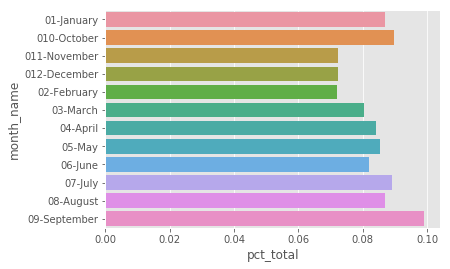

In [64]:
calendar_month_miss = calendar_clean.query("provided_flag=='MissingValue'").groupby(
    ['month_name', 'provided_flag']).size().to_frame('row_count').assign(
        pct_total=lambda x: x.row_count / x.row_count.sum())

sns.barplot(
    x='pct_total', y='month_name', data=calendar_month_miss.reset_index());

### Price Distributions by Month, RowSource, Dates

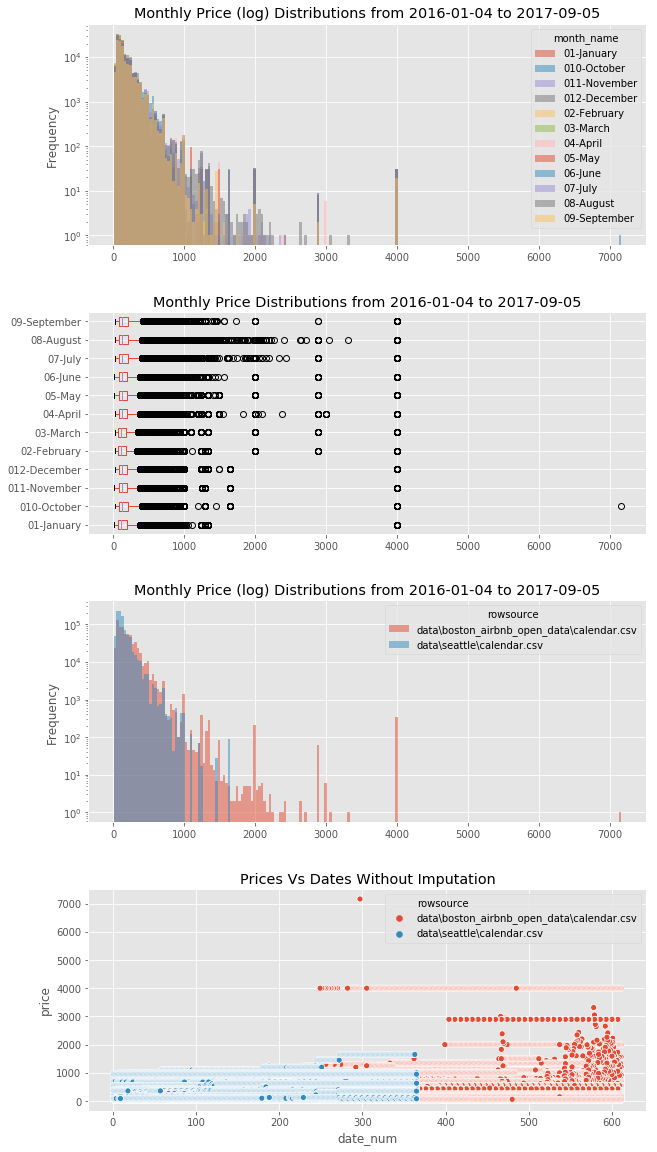

In [65]:
# Dataset groupings
calendar_price_bymonth = calendar_clean.reset_index(drop=True).pivot(
    columns='month_name', values='price')

calendar_price_bysource = calendar_clean.reset_index(drop=True)\
    .pivot(columns='rowsource', values='price')

# Title min max dates
max_date = str(calendar_clean.date.max().date())
min_date = str(calendar_clean.date.min().date())

# Starting subplot
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 20))

plt.subplots_adjust(hspace=.3)

calendar_price_bymonth.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}',
    ax=ax[0])

calendar_price_bymonth.plot.box(
    vert=False,
    title=f'Monthly Price Distributions from {min_date} to {max_date}',
    ax=ax[1])

calendar_price_bysource.plot.hist(
    bins=200,
    logy=True,
    alpha=.5,
    title=f'Monthly Price (log) Distributions from {min_date} to {max_date}', ax=ax[2])

plt.title('Prices Vs Dates Without Imputation')
sns.scatterplot(x='date_num', 
                y='price', 
                hue='rowsource', 
                data=calendar_clean, ax=ax[3])

plt.show()

### Price Relation with Availabity

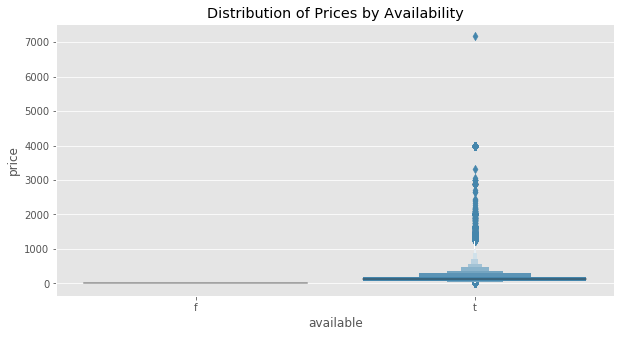

In [66]:
plt.figure(figsize=(10, 5))
plt.title("Distribution of Prices by Availability")
sns.boxenplot(
    x='available', y='price', data=calendar_clean.fillna(0));

### Calendar Removal or Imputation Results

Simply removing all null prices will remove 41.62% of the calendar data. Most of it will be from the Boston dataset. However, missing prices are related to unavailable listings or available = f (for False).

As much as we want to prevent such drastic removals, we cannot do imputations for these nulls. We want to predict prices of listings and it is obvious that prices for unavailable listings are 0. For this reason, we are removing any null prices or all unavailable listings.

### **Removing Null Prices or all Unavailable Listings** --RR

In [67]:
# Validator
available_count = calendar_clean.query("available=='t'").shape[0]
print(f"There are {available_count:2,.0f} available listings in the calendar dataset.")

# Removing all Nulls
calendar_removals = calendar_clean.dropna()

# Validating
kept_count = calendar_removals.shape[0]
print(f"There are {kept_count:2,.0f} listings in the calendar dataset after removals.")

There are 1,577,499 available listings in the calendar dataset.
There are 1,577,499 listings in the calendar dataset after removals.


### **Removing Irrelevant Columns** --RC

In [68]:
# Save date and date number for reference
references = calendar_removals[['date', 'date_num']]

In [69]:
drop_columns = ['available', 'rowsource', 'provided_flag', 
                'source_group_flag', 'month_name', 'date']

# Removing non-predictors
try: calendar_removals = calendar_removals.drop(drop_columns, axis=1)
except: pass

### Finishing the Calendar Data Preparation and Releasing Objects from Memory

In [70]:
# Copy calendar removals to the completed calendar
try:
    calendar_complete = calendar_removals.copy()
except:
    pass

del calendar_clean, 
del calendar_removals, 
del calendar_dup, 
del calendar_grp,
del calendar_missing, 
del calendar_month_miss, 
del calendar_price_bymonth,
del calendar_price_bysource, 
del calendar_rowsource_miss
del calendar_price_dups

calendar_complete.head()

,listing_id,price,date_num
365,3075044,65.0,597.0
366,3075044,65.0,596.0
367,3075044,65.0,595.0
368,3075044,75.0,594.0
369,3075044,75.0,593.0


### Checking Correlations of Final Calendar

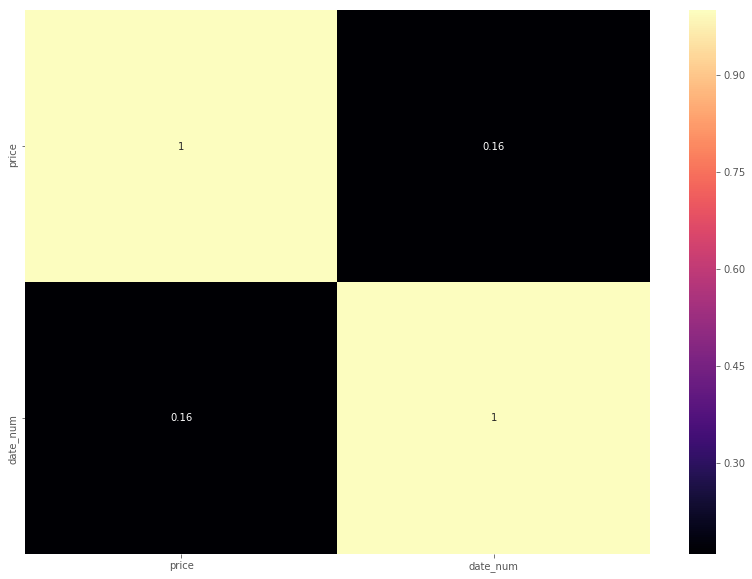

In [71]:
analysis = AnalysisStatus(calendar_complete, listings)
analysis.correlation_status(['date_num'])

Good. Alone with price the date number has at least a low correlation with price, which means that there is $r^2$ percentage of examplenation by daily movements. The rest can be attributed to other features that we are going to explore next.

## Listing Removals or Imputations

### Listings Null Analysis

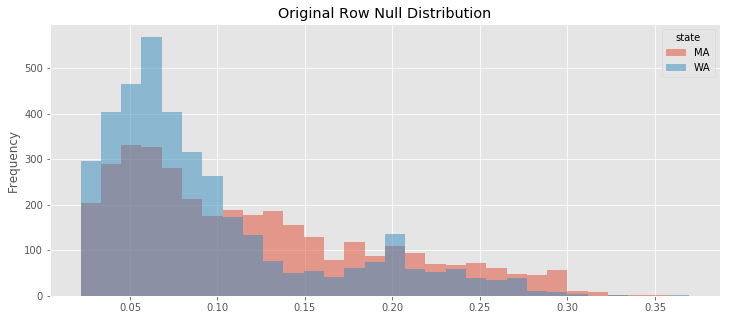

In [72]:
analysis.listing_row_null_dist(30, 'Original Row Null Distribution')               

We are not observing an alarming rate of rows with null values across it. However, some of these features might be irrelevant for the analysis, and we should remove them. There could be other variables that can be imputed with values. We will assess this distribution again after removals and imputations.

### Identifying Irrelevant Columns

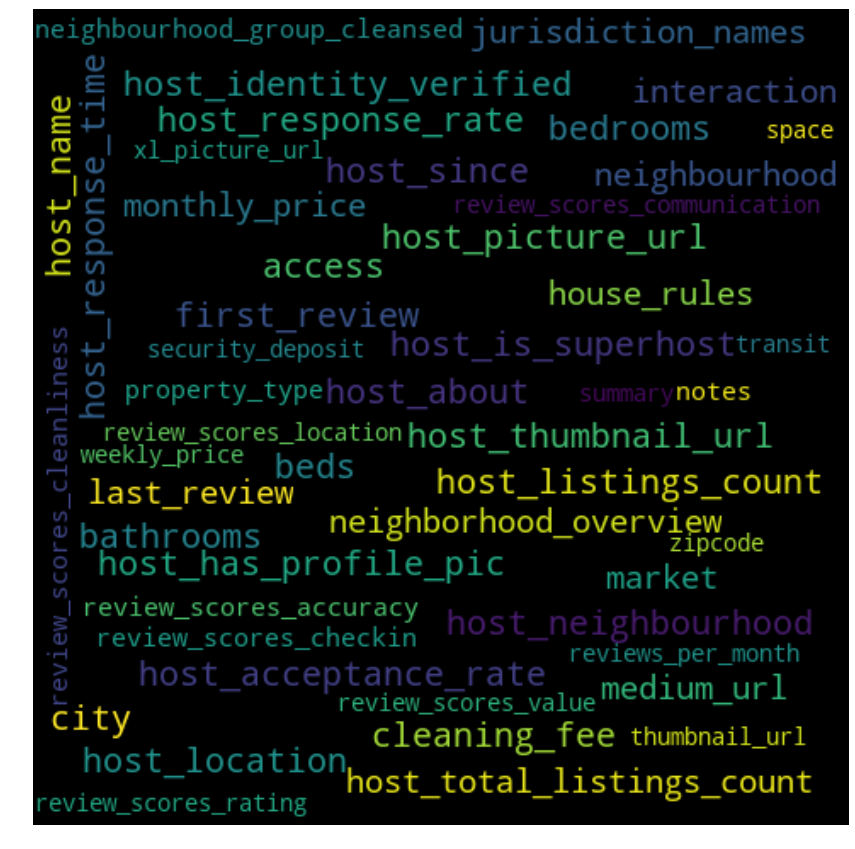

In [73]:
# target colmuns for imputations and transformations
target_columns = listings.isnull().sum().where(lambda x: x>0).dropna().index.tolist()
target_columns = ' '.join(target_columns)
target_columns

wordcloud = WordCloud(width=480, height=480, max_font_size=20, min_font_size=10).generate(target_columns)
plt.figure(figsize=(15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()


All of these features in the wordcloud need to be analyized for null relations to other feature values. But some of theme are irrelevant for the analysis such as those that finish with url.

### Columns to Remove due to Irrelevance

In [74]:
# Irrelevant columns
irrelevant_columns = listings.columns.str.contains('url|name|about|pic')
irrelevant_columns = listings.columns[irrelevant_columns].tolist()

# Show irrelevant features
listings[irrelevant_columns].head(1).T.style.set_caption("Irrelevant Features")

,0
host_about,"We are country and city connecting in our deck and garden. Enjoy our music room, books and flat screen TV with the pastoral backyard of hens, bees, rabbits and an organic garden."
host_has_profile_pic,t
host_name,Virginia
host_picture_url,https://a2.muscache.com/im/pictures/5936fef0-ba16-45bd-ac33-9226137d0763.jpg?aki_policy=profile_x_medium
host_thumbnail_url,https://a2.muscache.com/im/pictures/5936fef0-ba16-45bd-ac33-9226137d0763.jpg?aki_policy=profile_small
host_url,https://www.airbnb.com/users/show/31303940
jurisdiction_names,nan
listing_url,https://www.airbnb.com/rooms/12147973
medium_url,https://a2.muscache.com/im/pictures/c0842db1-ee98-4fe8-870b-d1e2af33855d.jpg?aki_policy=medium
name,Sunny Bungalow in the City


These, above, are irrelevant columns since they describe web addresses and names. So there is no value to them in a regression analysis. 

On the contrary **host_has_profile_pic** and **require_guest_profile_picture** might add value to the model.

### Null Row Values Exceeding 10%

In [75]:
analysis.null_row_feature_status(percentages=True, threshold=.10)

interaction                     0.725652
access                          0.716872
house_rules                     0.676753
monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
neighbourhood_group_cleansed    0.484263
jurisdiction_names              0.484263
notes                           0.483723
neighborhood_overview           0.330542
transit                         0.300419
host_about                      0.292854
cleaning_fee                    0.288667
space                           0.219641
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_location          0.199514
review_scores_value             0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
first_review                    0.186816
last_review                     0.186816
reviews_per_month               0.186816
host_acceptance_

### Assessing Transformations of Informational Features

#### Examples of Informational Columns with Missing Values

In [76]:
interest = ['']
iform_arguments = 'access|over|rule|notes|space|summary|transit|interaction|host_about|desc'
inform_columns = listings.filter(regex=iform_arguments).columns.tolist()
listings[inform_columns].head()

,access,description,host_about,house_rules,interaction,neighborhood_overview,notes,space,summary,transit
0,"You will have access to 2 bedrooms, a living r...","Cozy, sunny, family home. Master bedroom high...",We are country and city connecting in our deck...,Clean up and treat the home the way you'd like...,NaN,"Roslindale is quiet, convenient and friendly. ...",NaN,The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...","The bus stop is 2 blocks away, and frequent. B..."
1,Apt has one more bedroom (which I use) and lar...,Charming and quiet room in a second floor 1910...,I live in Boston and I like to travel and have...,Pet friendly but please confirm with me if the...,"If I am at home, I am likely working in my hom...","The room is in Roslindale, a diverse and prima...","If you don't have a US cell phone, you can tex...",Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,Plenty of safe street parking. Bus stops a few...
2,"I am living in the apartment during your stay,...","Come stay with a friendly, middle-aged guy in ...","I am a middle-aged, single male with a wide ra...","I encourage you to use my kitchen, cooking and...","ABOUT ME: I'm a laid-back, friendly, unmarried...",The LOCATION: Roslindale is a safe and diverse...,I am in a scenic part of Boston with a couple ...,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","PUBLIC TRANSPORTATION: From the house, quick p..."
3,The basement has a washer dryer and gym area. ...,Come experience the comforts of home away from...,My husband and I live on the property. He’s a...,- The bathroom and house are shared so please ...,We do live in the house therefore might be som...,Roslindale is a lovely little neighborhood loc...,Please be mindful of the property as it is old...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,There are buses that stop right in front of th...
4,You will have access to the front and side por...,"My comfy, clean and relaxing home is one block...",I work full time for a public school district....,"Please no smoking in the house, porch or on th...",I love my city and really enjoy sharing it wit...,"I love the proximity to downtown, the neighbor...",I have one roommate who lives on the lower lev...,"Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",From Logan Airport and South Station you have...


In [77]:
# Values with 1 should match this
listings[inform_columns].isnull().sum()

access                   5307
description                 0
host_about               2168
house_rules              5010
interaction              5372
neighborhood_overview    2447
notes                    3581
space                    1626
summary                   320
transit                  2224
dtype: int64

#### **Transforming Informational Columns** --T

In [384]:
listings_transform = listings.copy()

In [385]:
# Conducting Transformations and Imputations
provided_func = lambda x: x.isnull()
inform_transform = listings_transform[inform_columns].where(provided_func, 0).fillna(1)

# creating the new column for provided access information
listings_transform.loc[:, inform_columns] = inform_transform

In [386]:
# Matching 1 to provided information
listings_transform[inform_columns].sum()

access                   5307
description                 0
host_about               2168
house_rules              5010
interaction              5372
neighborhood_overview    2447
notes                    3581
space                    1626
summary                   320
transit                  2224
dtype: int64

#### Checking Correlations of Informational Features

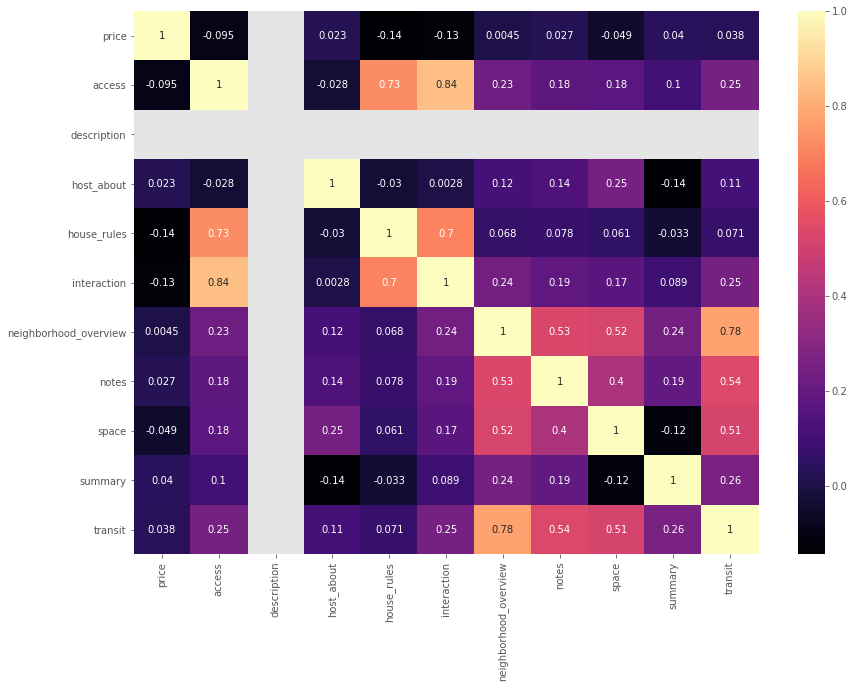

In [387]:
analysis.listings = listings_transform
analysis._merge()
analysis.correlation_status(inform_columns)

#### Checking Null Distributions After Transformations

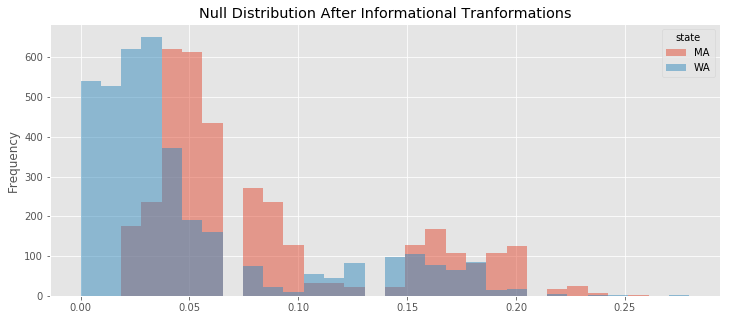

In [388]:
analysis.listing_row_null_dist(
    bins=30, title='Null Distribution After Informational Tranformations')

#### Informational Feature Transformation Results

These informational columns are not substantially correlated with price. For this reason, they will be removed from the dataset, with the exception of **house_rules** or **interaction**. They have the biggest correlation with price. However, they are also heavily correlated with each other. For this reason, we are going to pick just **house_rules** because it has the highest correlation with price. In the end, it is going to be just a close call for the feature since if the model is performing well without it, we will remove it. We are adding it to the **predictors**, which will keep track of the features that will be initially used in the model.

We now have less row nulls than beofre. It is looking much cleaner.

In [389]:
analysis.null_row_feature_status(percentages=True)

monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
jurisdiction_names              0.484263
neighbourhood_group_cleansed    0.484263
cleaning_fee                    0.288667
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_value             0.199514
review_scores_location          0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
first_review                    0.186816
reviews_per_month               0.186816
last_review                     0.186816
host_acceptance_rate            0.168040
host_response_rate              0.134270
host_response_time              0.134270
neighbourhood                   0.129542
medium_url                      0.124139
thumbnail_url                   0.124139
xl_picture_url                  0.124139
dtype: float64

### Assessing Dolar Value Features --C

In [390]:
# Preparing for tranformations
clean_func = lambda x: cleaning_dollar(x)
dollar_columns = listings_transform.columns.str.contains('fee|price|deposit|extra')
dollar_columns = listings_transform.columns[dollar_columns].tolist()

listings_transform.loc[:, dollar_columns] = listings_transform[
    dollar_columns].apply(clean_func)

#### Checking Correlations for Dollar Features

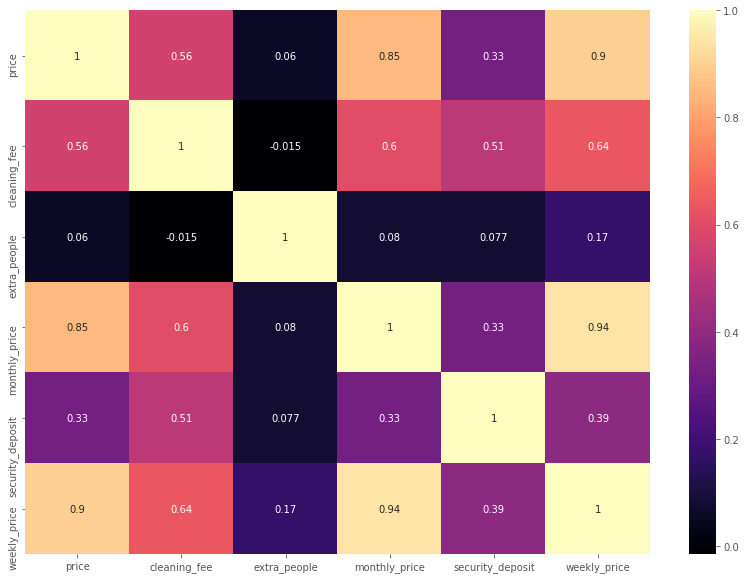

In [391]:
analysis.listings = listings_transform
analysis._merge()
analysis.correlation_status(dollar_columns)

#### **Removing Pricing Derived Feautres** --RC

In [392]:
drop_dollarder = ['monthly_price', 'weekly_price']
listings_transform.drop(drop_dollarder, axis=1, inplace=True)

#### Imputations of Zero Fees and Deposits

In [393]:
fee_columns = ['cleaning_fee', 'security_deposit']
listings_transform.loc[:, fee_columns] = listings_transform[fee_columns].fillna(0)

#### Checking Null Distributions After Removal of Pricing Derived Features and Imputations

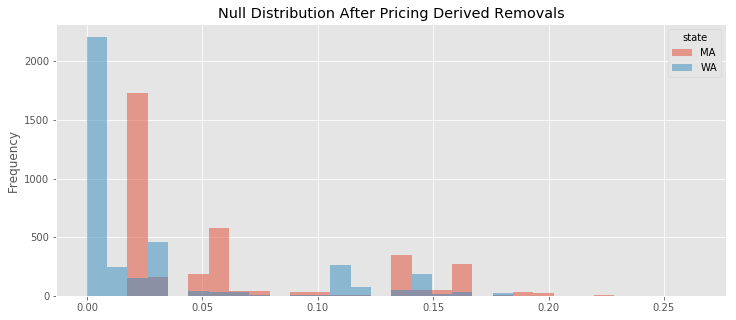

In [394]:
analysis.listing_row_null_dist(
    bins=30, title='Null Distribution After Pricing Derived Removals')

#### Dollar Features Results

We can see that there is no use for using **monthly_price** and **weekly_price** to predict price because that is a bit redundant--no wonder the are heavily correlated. However, **cleaning_fee** and **security_deposit** are the main drivers of listing price. Thus, we are dropping listing price derived features and keeping the fees, which are additions to the price.

The null rows are mosthly clean at this time. We are doing a bit more cleaning, and we will be done.

In [395]:
analysis.null_row_feature_status(percentages=True)

jurisdiction_names              0.484263
neighbourhood_group_cleansed    0.484263
review_scores_accuracy          0.200054
review_scores_checkin           0.199649
review_scores_value             0.199514
review_scores_location          0.199514
review_scores_cleanliness       0.198703
review_scores_communication     0.198433
review_scores_rating            0.197217
reviews_per_month               0.186816
last_review                     0.186816
first_review                    0.186816
host_acceptance_rate            0.168040
host_response_rate              0.134270
host_response_time              0.134270
neighbourhood                   0.129542
medium_url                      0.124139
thumbnail_url                   0.124139
xl_picture_url                  0.124139
dtype: float64

### Assessing Missing Geographical Features

#### 5 Sample Rows of Geographical Columns

In [396]:
# Geo with nulls
geo_null_cololumns = [
    'jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood',
    'host_neighbourhood', 'host_location', 'city'
]

# Geo complete
geo_comp_columns = ['state', 'street']

listings_transform[geo_null_cololumns + geo_comp_columns].sample(5)

,jurisdiction_names,neighbourhood_group_cleansed,neighbourhood,host_neighbourhood,host_location,city,state,street
1999,NaN,NaN,Beacon Hill,South Boston,"Boston, Massachusetts, United States",Boston,MA,"Garden Street, Boston, MA 02114, United States"
2426,NaN,NaN,Fenway/Kenmore,Back Bay,US,Boston,MA,"Peterborough St, Boston, MA 02215, United States"
3843,WASHINGTON,Queen Anne,Queen Anne,Queen Anne,"Seattle, Washington, United States",Seattle,WA,"Aurora Avenue North, Seattle, WA 98109, United..."
6117,WASHINGTON,Other neighborhoods,Bryant,Bryant,"Seattle, Washington, United States",Seattle,WA,"36th Avenue Northeast, Seattle, WA 98105, Unit..."
3738,WASHINGTON,Ballard,Ballard,Ballard,"Seattle, Washington, United States",Seattle,WA,"5th Avenue Northwest, Seattle, WA 98107, Unite..."


#### Jurisdiction and State

In [397]:
listings_transform.fillna('missing').groupby(['state', 'jurisdiction_names']).size()

state  jurisdiction_names
MA     missing               3585
WA     WASHINGTON            3818
dtype: int64

#### Neighbourhood Features

In [398]:
match_func = lambda x: x.neighbourhood == x.host_neighbourhood
listings_transform[[
    "neighbourhood_group_cleansed", "neighbourhood", "host_neighbourhood",
    "host_location", "neighbourhood_cleansed"
]].astype(str).assign(match=match_func).query("match==False").sample(5)

,neighbourhood_group_cleansed,neighbourhood,host_neighbourhood,host_location,neighbourhood_cleansed,match
2459,nan,Fenway/Kenmore,West End,"New York, New York, United States",Fenway,False
2256,nan,Fenway/Kenmore,West End,"New York, New York, United States",Fenway,False
5066,Downtown,Central Business District,Belltown,"Seattle, Washington, United States",Central Business District,False
6870,Other neighborhoods,Broadview,Ballard,"Seattle, Washington, United States",Bitter Lake,False
1252,nan,Back Bay,Cambridge,"Cambridge, Massachusetts, United States",Back Bay,False


#### Missing City

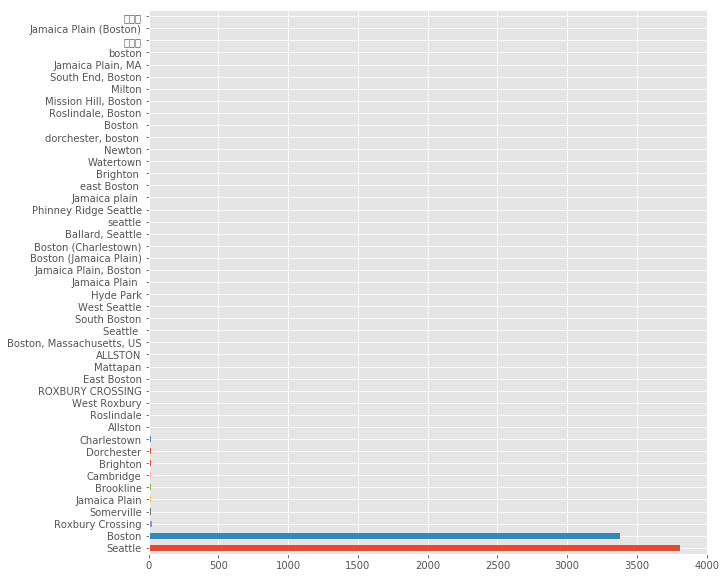

In [399]:
# Checking sparsity
listings_transform.city.value_counts().plot.barh(figsize=(10, 10));

#### Grouping Sparse Classes for City

In [400]:
# Fixing sparsity issue
eng_group_bos = {True:'Boston'}
eng_group_sea = {True:'Seattle'}
eng_group_city = lambda x: x.str.contains('Boston|Seattle')

# Grouping Seattle Areas
fill_sea = listings_transform.city.str.contains('seattle', case=False)\
    .map(eng_group_sea)

# Grouping Boston Areas
fill_bos = listings_transform.city.str.contains('boston', case=False)\
    .map(eng_group_bos)

# Grouping Other Areas
group_sparse = fill_bos.fillna(fill_sea).where(eng_group_city, 'Other')

# Applying sparcity fix to city
listings_transform.loc[:, 'city'] = group_sparse

,city
Seattle,51.56%
Boston,45.93%
Other,2.51%


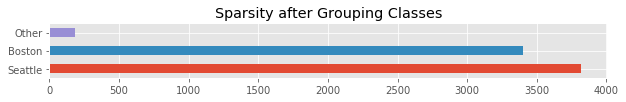

In [401]:
# Plotting sparsity
listings_transform.city.value_counts().plot.barh(
    figsize=(10, 1), title='Sparsity after Grouping Classes')

# Checking sparsity
(listings_transform.city.value_counts()/listings_transform.city.count())\
    .to_frame().style.format("{:2.2%}")

####  Geographical Features Results

We found that **jurisdiction_names** are related identically to state and are completely missing for Massachusetts. Thus we are removing it. Also **neighbourhood_group_cleansed** has too many missing values to map with zipcodes to extract the neighborhood. We could get a dataset to map this. But for now, we will just remove it. There are some free zip code databases online that we can use to extract these. However, although **neighbourhood** has some duplicates and the process to extract those using zipcodes is not set yet. We are keeping this feature as predictor and converting the nulls to dummies.

We are removing **jurisdiction_names, neighbourhood_group_cleansed, and neighbourhood** from the listings and adding them to a tryout dataframe so we can pass it to the model for curiosity's sake. 

As for **city**, even though the nulls where insignificant, the sparsity of city groups were more concentrated in Boston and Seattle. We can use this feature but we need to group these sparse classes into other. However, some of these cities pertains to Boston, so we will need to map those.

In [402]:
drop_columns = ['jurisdiction_names', 'neighbourhood_group_cleansed', 'neighbourhood']
tryout = listings_transform[drop_columns]
listings_transform.drop(drop_columns, axis=1, inplace=True)

In [403]:
analysis.null_row_feature_status(percentages=True)

review_scores_accuracy         0.200054
review_scores_checkin          0.199649
review_scores_value            0.199514
review_scores_location         0.199514
review_scores_cleanliness      0.198703
review_scores_communication    0.198433
review_scores_rating           0.197217
first_review                   0.186816
last_review                    0.186816
reviews_per_month              0.186816
host_acceptance_rate           0.168040
host_response_rate             0.134270
host_response_time             0.134270
medium_url                     0.124139
thumbnail_url                  0.124139
xl_picture_url                 0.124139
dtype: float64

### Assessing Reviews

#### Reviews where Number of Reviews where not Zero

In [404]:
# Columns related to reviews
review_columns = listings_transform.columns[
    listings_transform.columns.str.contains('review')]
review_columns = ['id'] + review_columns.tolist()

listings_transform[review_columns].query(
    "number_of_reviews!=0").isnull().sum().to_frame('missing')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


#### Reviews where Number of Reviews where Zero

In [405]:
listings_transform[review_columns].query("number_of_reviews==0").isnull().sum(
).to_frame('missing')

,missing
id,0
first_review,1383
last_review,1383
number_of_reviews,0
review_scores_accuracy,1383
review_scores_checkin,1383
review_scores_cleanliness,1383
review_scores_communication,1383
review_scores_location,1383
review_scores_rating,1383


#### Reviews where Number of Reviews where not Zero Including Reviews Dataset Merge

In [406]:
listings_transform[review_columns].query("number_of_reviews!=0").merge(
    reviews.groupby('listing_id', as_index=False).sum(),
    left_on='id',
    right_on='listing_id',
    how='left',
    suffixes=['', '_reviews']).isnull().sum().to_frame('missing')

,missing
id,0
first_review,0
last_review,0
number_of_reviews,0
review_scores_accuracy,98
review_scores_checkin,95
review_scores_cleanliness,88
review_scores_communication,86
review_scores_location,94
review_scores_rating,77


####  **Engineering review_lag and review_rate** --E

In [407]:
# creating the lag between first and last review
day_func = lambda x: x.days
diff_func = lambda x: (pd.to_datetime(x.last_review) - pd.to_datetime(
    x.first_review)).apply(day_func)
reate_func = lambda x: (x.review_lag / x.number_of_reviews)

# engineering review lag
listings_transform = listings_transform.assign(review_lag=diff_func)

# engineering review rate
listings_transform = listings_transform.assign(review_rate=reate_func)

# dropping fist_review and last_review
review_dates = ['first_review', 'last_review']
listings_transform.drop(review_dates, axis=1, inplace=True)

#### Reviews Results

Where the  number of reviews is 0, all review data is Null. This means that these Nulls are meaningful for the analysis. They actually represent the absence of ratings. They should be set as dummies to identify when listings have no ratings.

Where the number of reviews is not 0, there are some review scores that are Null. However, the reviews dataset contains the comments for these reviews. Given that the reviews dataset links perfectly with the missing values, we could apply natural language processing to predict the missing ratings. However, since there are no substantial missing values for these scores, we are leaving the nulls for now. We can later apply NLP to predict them if the predicting model does not perform as desired (it is not expected since the missing values are so insignificant).

We are removing **first_review** and **last_review** and replacing it with review_lag to account for the dates between the first review and the last review. We are also engineering the rate of reviews by dividing the **review_lag** by the **number_of_reviews**.

**Engeniering Description**:
* For the lag, we substracted the frist review date from the last review date.
* For the review rate, we divided the review lag by the number of reviews, which give us the rate of reviews between the first review date and the last review date.

In [408]:
analysis.listings = listings_transform
analysis._merge()

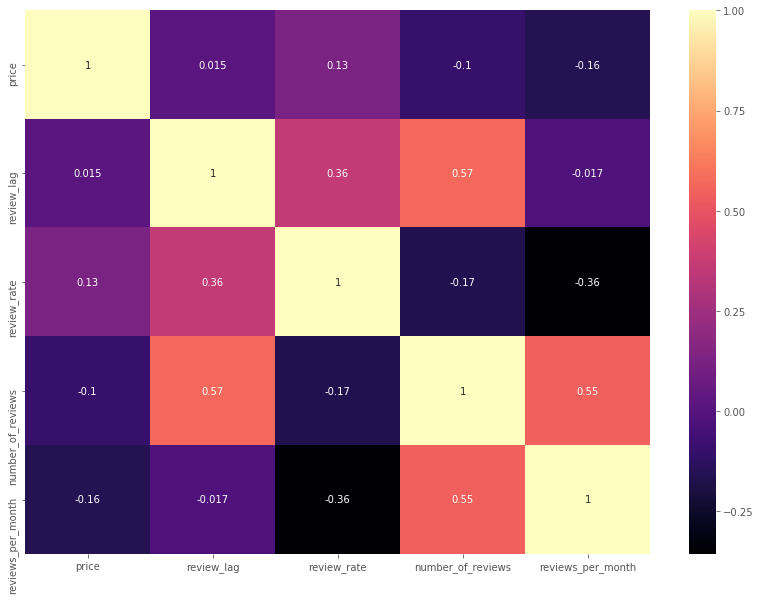

In [409]:
analysis.correlation_status(['review_lag', 'review_rate', 'number_of_reviews', 'reviews_per_month'])

We can see that the only valuable engineered feature is the **review_rate**. The **review_lag** is insignificant. And the initial feature number of reviews is insignificant by itself. The review rate at least has a low significance with price.

### **Removing Other Irrelevant Features** --RC

In [410]:
possible_columns = ['host_has_profile_pic', 'require_guest_profile_picture']
drop_columns = [
    i for i in irrelevant_columns
    if i not in possible_columns + ['jurisdiction_names']
]

In [411]:
listings_transform.drop(drop_columns, axis=1, inplace=True)

In [412]:
analysis.null_row_feature_status(percentages=True)

review_scores_accuracy         0.200054
review_scores_checkin          0.199649
review_scores_value            0.199514
review_scores_location         0.199514
review_scores_cleanliness      0.198703
review_scores_communication    0.198433
review_scores_rating           0.197217
review_rate                    0.186816
reviews_per_month              0.186816
review_lag                     0.186816
host_acceptance_rate           0.168040
host_response_time             0.134270
host_response_rate             0.134270
dtype: float64

We ended up removing all irrelevant features except for  the picture related columns, which could be benefetial to the model.

### Assessing Nulls at the Row Level

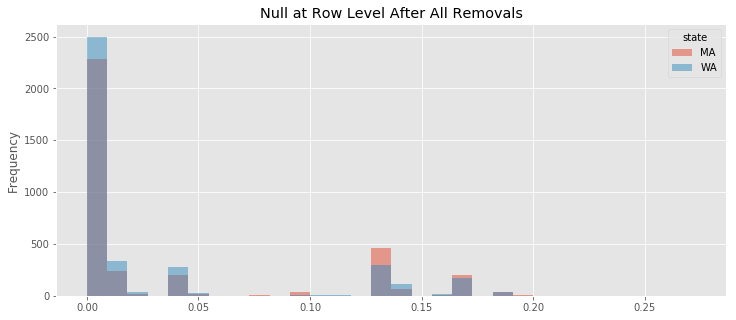

In [413]:
analysis.listing_row_null_dist(30, 'Null at Row Level After All Removals')

In [414]:
(pd.cut(
    listings_transform.row_null_pct, bins=np.arange(0, 1, .03),
    right=False).value_counts() / listings_transform.shape[0]
 ).where(lambda x: x > 0).dropna().to_frame("Removal%").reset_index().rename(
     columns={'index': 'Null at Row'})

,Null at Row,Removal%
0,"[0.0, 0.03)",0.730380
1,"[0.12, 0.15)",0.127111
2,"[0.03, 0.06)",0.070647
3,"[0.15, 0.18)",0.053222
4,"[0.18, 0.21)",0.009456
5,"[0.09, 0.12)",0.007835
6,"[0.06, 0.09)",0.001081
7,"[0.27, 0.3)",0.000270


As we can see now, the number of nulls at the row level is very low. At this time we are going to remove anything with 12% of nulls at the row level. It will preserve 73% of the data for analysis.

### Splitting, Engineering, and Removing amenities and host_verifications --E RC

In [415]:
# Instantiationg encoder
ds = DummySplit(listings_transform)

# Original example
listings_transform[['amenities']].head()

,amenities
0,"{TV,""Wireless Internet"",Kitchen,""Free Parking ..."
1,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
2,"{TV,""Cable TV"",""Wireless Internet"",""Air Condit..."
3,"{TV,Internet,""Wireless Internet"",""Air Conditio..."
4,"{Internet,""Wireless Internet"",""Air Conditionin..."


In [416]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy('amenities')
ds.add_dummies(drop_original=True)
amenities_columns = ds.dummy_columns[:]
ds.dummy_frame.head()

,TV,WirelessInternet,Kitchen,FreeParkingonPremises,Petsliveonthisproperty,Dogs,Heating,FamilyKidFriendly,Washer,Dryer,...,Otherpets,WasherDryer,SmokingAllowed,SuitableforEvents,WheelchairAccessible,ElevatorinBuilding,Pool,Doorman,PaidParkingOffPremises,FreeParkingonStreet
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [417]:
# Original example
listings_transform[['host_verifications']].head()

,host_verifications
0,"['email', 'phone', 'facebook', 'reviews']"
1,"['email', 'phone', 'facebook', 'linkedin', 'am..."
2,"['email', 'phone', 'reviews', 'jumio']"
3,"['email', 'phone', 'reviews']"
4,"['email', 'phone', 'reviews', 'kba']"


In [418]:
# split add and drop -- save columns and example of transformations
ds.split_create_dummy(feature_name='host_verifications')
ds.add_dummies(drop_original=True)
host_verifications = ds.dummy_columns[:]
ds.dummy_frame.head()

,email,phone,facebook,reviews,linkedin,amex,jumio,kba,manualonline,manualoffline,google,sentid,weibo,photographer
0,1,1,1,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,0,0,0,0,0,0,0
2,1,1,0,1,0,0,1,0,0,0,0,0,0,0
3,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,1,1,0,1,0,0,0,1,0,0,0,0,0,0


In [419]:
# release memory
del ds

#### Checking Correlation of New Features

In [420]:
analysis.listings = listings_transform
analysis._merge()

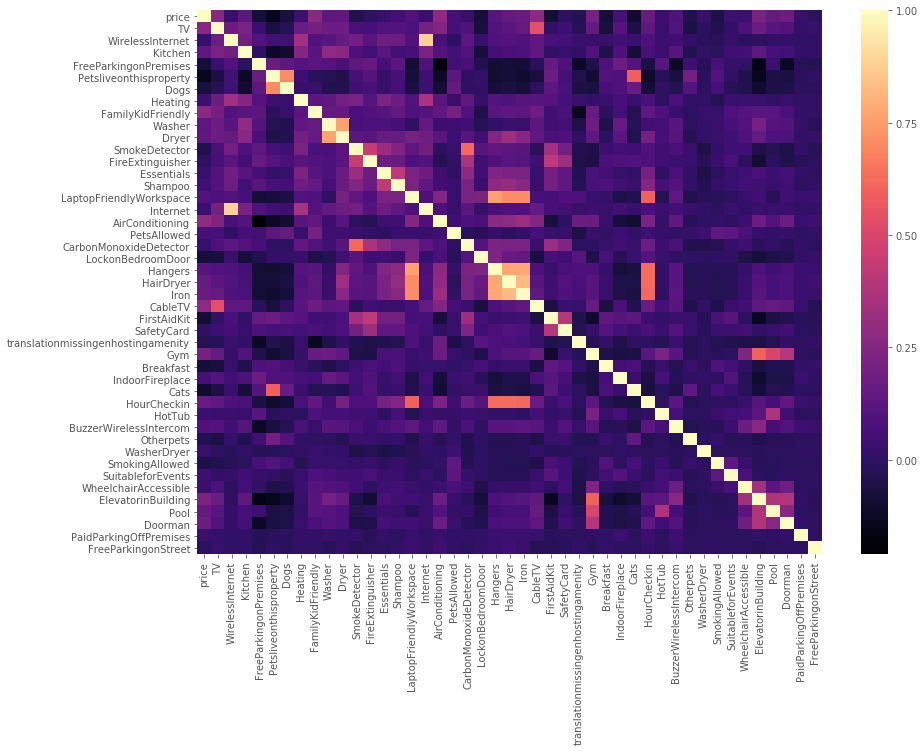

In [421]:
analysis.correlation_status(amenities_columns, show_values=False)

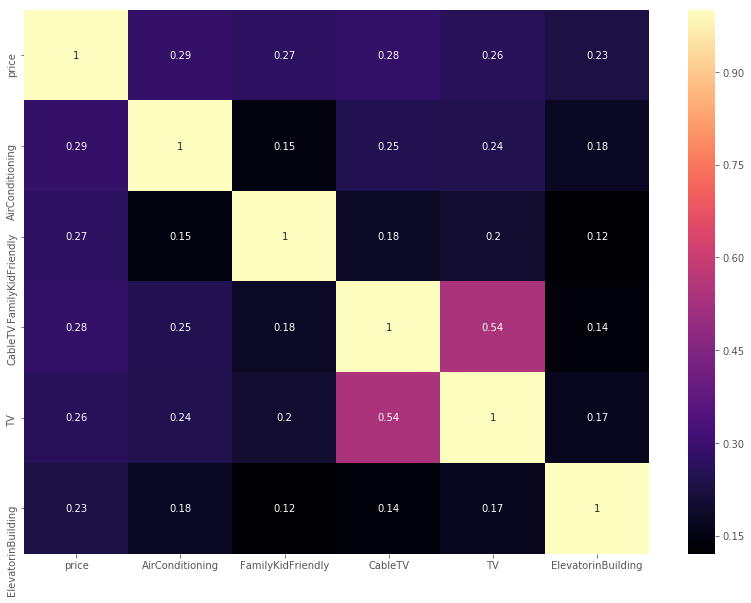

In [455]:
scope = ['AirConditioning', 'FamilyKidFriendly', 'CableTV', 'TV', 'ElevatorinBuilding']
analysis.correlation_status(scope, show_values=True)

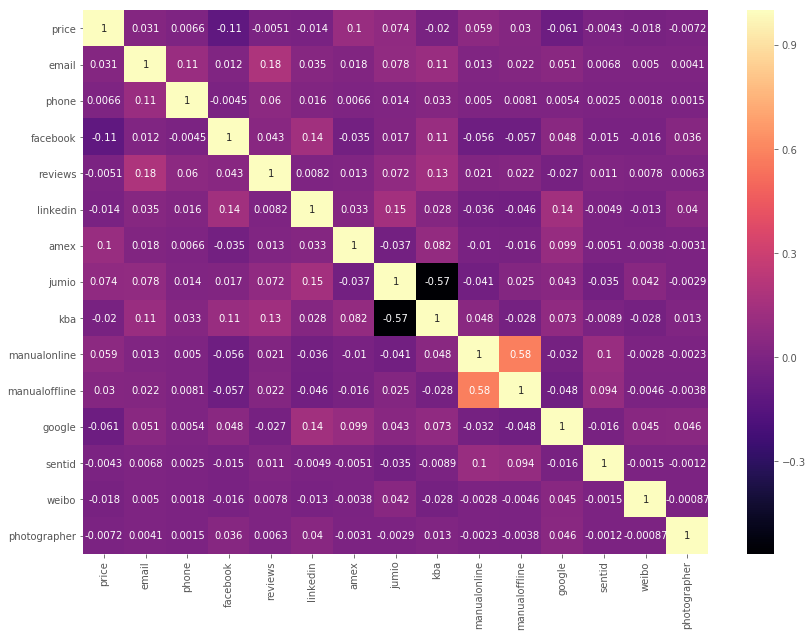

In [422]:
analysis.correlation_status(host_verifications, show_values=True)

#### Amenities and Host Verification Results

In the amenities we found that some features stand out with moderate correlations--AirConditioning, FamilyKidFriendly, CableTV, TV, and ElevatorinBuilding were some of them. These features will add values to the model. However, they are a slightly correlated with each other, except for FamilyKidFriendly and ElevatorinBuilding.

On the contrary, host_verividations did not have any valuable features extracted, except for amex, which scored a $r$ of .10. Perhaps, we can add it to the model at the end.

We are adding to the model the highest correlated features that have the lowest multicollinearity with each other.

### Final Transformations and Removals

#### **Removing Irrelevant Columns** -- RC

In [423]:
removals = [
    'calendar_updated', 'experiences_offered',
    'is_location_exact', 'rowsource', 'zipcode', 'street'
]

listings_transform.drop(removals, axis=1, inplace=True)

#### **Cleaning Percentages** -- C

In [424]:
def cleaning_percent(series):
    """
    To clean percentages and convert to ratio format
    """    
    join_func = lambda x: ''.join(x) if type(x)!=float else x
        
    series = series.str.findall('[^%]').apply(join_func).astype(float)/100
    
    return series

In [425]:
cleaning = ['host_acceptance_rate', 'host_response_rate']
listings_transform.loc[:, 'host_acceptance_rate'] = cleaning_percent(
    listings_transform.host_acceptance_rate)

listings_transform.host_acceptance_rate.head()

0     NaN
1    1.00
2    0.88
3    0.50
4    1.00
Name: host_acceptance_rate, dtype: float64

In [426]:
listings_transform.loc[:, 'host_response_rate'] = cleaning_percent(
    listings_transform.host_response_rate)

listings_transform.host_response_rate.head()

0    NaN
1    1.0
2    1.0
3    1.0
4    1.0
Name: host_response_rate, dtype: float64

#### Transformations of t/f Values

In [427]:
transform = [
    'host_has_profile_pic', 'host_identity_verified', 'host_is_superhost',
    'instant_bookable', 'require_guest_phone_verification', 'requires_license',
    'require_guest_profile_picture'
]

listings_transform.loc[:, transform] = listings_transform[transform].apply(
    lambda x: x.map({
        'f': 1,
        't': 0
    }))

listings_transform[transform].head()

,host_has_profile_pic,host_identity_verified,host_is_superhost,instant_bookable,require_guest_phone_verification,requires_license,require_guest_profile_picture
0,0.0,1.0,1.0,1,1,1,1
1,0.0,0.0,1.0,0,1,1,1
2,0.0,0.0,0.0,1,1,1,0
3,0.0,1.0,1.0,1,1,1,1
4,0.0,0.0,0.0,1,1,1,1


#### **Engieneering host_lifetime from  host_since and calendar_updated** -- E

In [448]:
engieneering = ['host_since', 'calendar_last_scraped']

# Engineering feature by subracting
host_lifetime = listings_transform.calendar_last_scraped.apply(
    pd.to_datetime) - listings_transform.host_since.apply(pd.to_datetime)

# Extracting date number
host_lifetime = host_lifetime.apply(lambda x: x.days)

# Deleting original from dataset
listings_transform.drop(engieneering, axis=1, inplace=True)

# Adding engineered feature to dataset
listings_transform['host_lifetime'] = host_lifetime

In [449]:
analysis.listings = listings_transform
analysis._merge()

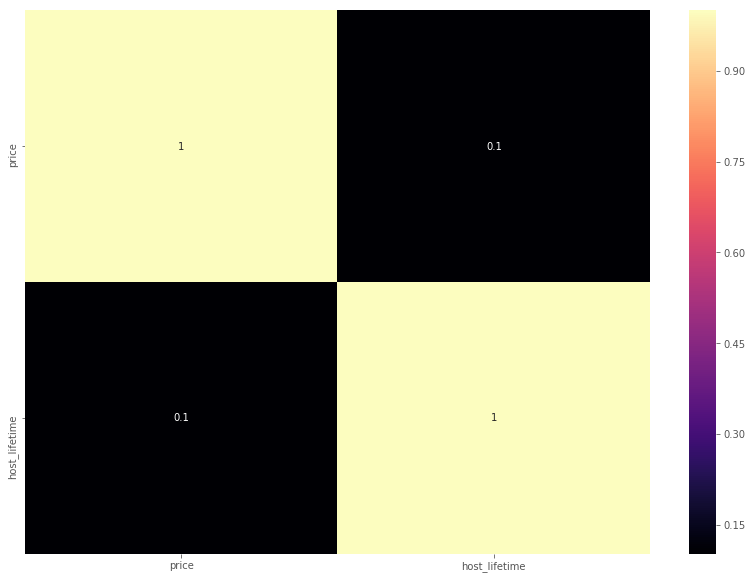

In [450]:
analysis.correlation_status(['host_lifetime'])

#### Engineered Feature Results

 A correlation of .1 is a small correlation. However, it could be beneficial to the model by a small margin. We will test the model with the highest correlated features first and will add some like this one to it to attempt to improve its scores.

### Applying One-Hot Encoder

In [454]:
listings_transform.select_dtypes(include=object).sample(2).T

,2774,5192
bed_type,Real Bed,Real Bed
cancellation_policy,flexible,moderate
city,Boston,Seattle
country,United States,United States
country_code,US,US
host_location,US,"Seattle, Washington, United States"
host_neighbourhood,Mattapan,First Hill
host_response_time,within an hour,within an hour
market,Boston,Seattle
neighbourhood_cleansed,Dorchester,First Hill


<div class="mark">
# Todo: 

* The rest of the nulls are insignificant so we are just going to remove nulls at a row basis.
* Drop any irrelevant features
* We are engineering from last and first review
* The next step is vectorizing all classes
* Validate for data integrity
* Instantiate Model
* The good stuff</div><i class="fa fa-lightbulb-o "></i>

# Modeling & Visualizations

# Evaluating Results

# Conclussion